In [1]:
import psycopg2
import time
import random
from collections import defaultdict

In [2]:
try:
    conn = psycopg2.connect(
        dbname="Sparsity",
        user="postgres",
        password="",
        host="localhost",
        port="5432",
    )
    cursor = conn.cursor()
    print("Connected to database")
except Exception as e:
    print("Error connecting to database")
    print(e)

Connected to database


In [3]:
def generate(num_tuples, sparsity, num_attributes):
    try:
        # Alte Tabelle löschen, falls vorhanden
        cursor.execute("DROP TABLE IF EXISTS H;")

        # Tabelle H erstellen
        columns = ["oid SERIAL PRIMARY KEY"]
        for i in range(1, num_attributes + 1):
            if i % 2 == 0:
                columns.append(f"a{i} INTEGER")
            else:
                columns.append(f"a{i} VARCHAR(50)")
        create_table_query = f"CREATE TABLE H ({', '.join(columns)});"
        cursor.execute(create_table_query)

        # Begrenzung für Attributwerte (maximal 5-mal vorkommen)
        value_counts = defaultdict(int)
        allowed_values = ["a", "b", "c"]

        # Daten einfügen
        for oid in range(1, num_tuples + 1):
            values = []
            for i in range(1, num_attributes + 1):
                if random.random() < sparsity:
                    values.append("NULL")
                else:
                    if i % 2 == 0:
                        values.append(str(random.randint(1, 100)))
                    else:
                        # Begrenzung auf max. 5 Vorkommen pro Wert
                        valid_choices = [
                            v
                            for v in allowed_values
                            if value_counts[v]
                            < num_attributes * num_tuples / 2 * (1 - sparsity)
                        ]
                        if valid_choices:
                            chosen_value = random.choice(valid_choices)
                            values.append(f"'{chosen_value}'")
                            value_counts[chosen_value] += 1
                        else:
                            values.append("'z'")
            insert_query = f"INSERT INTO H ({', '.join([f'a{i}' for i in range(1, num_attributes + 1)] )}) VALUES ({', '.join(values)});"
            cursor.execute(insert_query)

        conn.commit()
        print(
            f"Tabelle H mit {num_tuples} Tupeln und {num_attributes} Attributen erstellt."
        )
    except (Exception, psycopg2.Error) as error:
        print("Fehler in generate():", error)

In [4]:
def h2v(cursor, table_name, v_table_name):
    # Lösche bestehende Tabellen
    cursor.execute(f"DROP TABLE IF EXISTS {v_table_name}_string CASCADE;")
    cursor.execute(f"DROP TABLE IF EXISTS {v_table_name}_int CASCADE;")
    cursor.execute(f"DROP TABLE IF EXISTS {v_table_name}_all CASCADE;")

    # Erstelle Tabellen für String- und Integer-Werte
    cursor.execute(
        f"""
        CREATE TABLE {v_table_name}_string (
            oid INTEGER,
            key VARCHAR(50),
            value VARCHAR(50)
        );
    """
    )
    cursor.execute(
        f"""
        CREATE TABLE {v_table_name}_int (
            oid INTEGER,
            key VARCHAR(50),
            value INTEGER
        );
    """
    )

    # Hole Spaltennamen und Datentypen aus dem Katalog
    cursor.execute(
        f"""
        SELECT column_name, data_type
        FROM information_schema.columns
        WHERE table_name = '{table_name}' AND column_name != 'oid';
    """
    )

    columns = cursor.fetchall()

    for column, dtype in columns:
        if dtype in ["character varying", "text"]:  # String-Spalte
            cursor.execute(
                f"""
                INSERT INTO {v_table_name}_string (oid, key, value)
                SELECT oid, '{column}', {column}
                FROM {table_name}
                WHERE {column} IS NOT NULL;
            """
            )
        elif dtype in ["integer", "bigint"]:  # Integer-Spalte
            cursor.execute(
                f"""
                INSERT INTO {v_table_name}_int (oid, key, value)
                SELECT oid, '{column}', {column}
                FROM {table_name}
                WHERE {column} IS NOT NULL;
            """
            )

    # Erstelle eine vereinende Sicht (optional, falls benötigt)
    cursor.execute(f"DROP TABLE IF EXISTS {v_table_name}_all;")
    cursor.execute(
        f"""
        CREATE TABLE {v_table_name}_all AS
        SELECT oid, key, value::TEXT as value FROM {v_table_name}_string
        UNION ALL
        SELECT oid, key, value::TEXT as value FROM {v_table_name}_int;
    """
    )

    conn.commit()

In [5]:
# h2v(cursor, "h", "v")

In [6]:
def v2h(cursor, v_table_name, h_view_name, num_attributes):
    cursor.execute(f"DROP VIEW IF EXISTS {h_view_name};")

    select_parts = []
    join_parts = []

    for i in range(1, num_attributes + 1):
        attr = f"a{i}"
        table = f"{v_table_name}_int" if i % 2 == 0 else f"{v_table_name}_string"
        cast_type = "INTEGER" if i % 2 == 0 else "VARCHAR(50)"

        select_parts.append(f"v{i}.value::{cast_type} AS {attr}")
        join_parts.append(
            f"LEFT JOIN {table} AS v{i} ON base.oid = v{i}.oid AND v{i}.key = '{attr}'"
        )

    select_clause = ",\n    ".join(select_parts)
    join_clause = "\n    ".join(join_parts)

    cursor.execute(
        f"""
        CREATE VIEW {h_view_name} AS
        SELECT base.oid,
            {select_clause}
        FROM (SELECT DISTINCT oid FROM {v_table_name}_string 
            UNION SELECT DISTINCT oid FROM {v_table_name}_int) AS base
        {join_clause};
    """
    )
    conn.commit()

In [7]:
# v2h(cursor, "v", "h_transform", 6)

In [8]:
def benchmark(cursor, table_name, num_queries=1000, silent=False):

    # Anzahl der Attribute ermitteln
    cursor.execute(
        f"""
        SELECT COUNT(*) 
        FROM information_schema.columns 
        WHERE table_name = '{table_name.lower()}';
    """
    )
    num_attributes = cursor.fetchone()[0] - 1  # oid nicht zählen

    start_time = time.time()
    for _ in range(num_queries):
        query_type = random.choice(["single_oid", "attribute_query"])

        if query_type == "single_oid":
            oid = random.randint(1, 10000)
            cursor.execute(f"SELECT * FROM {table_name} WHERE oid = {oid};")
        else:
            attr_num = random.randint(1, num_attributes)
            if attr_num % 2 == 0:
                attr_val = random.randint(1, 100)
            else:
                attr_val = random.choice(["'a'", "'b'", "'c'"])
            cursor.execute(
                f"SELECT oid FROM {table_name} WHERE a{attr_num} = {attr_val};"
            )

    elapsed_time = time.time() - start_time
    if not silent:
        print(f"Executed {num_queries} queries in {elapsed_time:.2f} seconds." )
    return elapsed_time


def get_storage_size(cursor, table_name, silent=False):
    """Gibt den Speicherverbrauch in MB zurück"""
    cursor.execute(f"SELECT pg_total_relation_size('{table_name}');")
    size_bytes = cursor.fetchone()[0]
    size_mb = size_bytes / (1024 * 1024)
    if not silent:
        print(f"Speicherverbrauch von {table_name}: {size_mb:.2f} MB")
    return size_mb

In [9]:
def get_storage_size(cursor, table_name):
    cursor.execute(f"SELECT pg_total_relation_size('{table_name}');")
    size_bytes = cursor.fetchone()[0]
    size_mb = size_bytes / (1024 * 1024)  # Umrechnung in MB
    print(f"Speicherverbrauch von {table_name}: {size_mb:.2f} MB")
    return size_mb

In [10]:
# benchmark(cursor, "h", 1000)
# Speicherverbrauch für H und V bestimmen
# get_storage_size(cursor, "h")

In [11]:
def optimize_v(cursor, v_table_name):
    cursor.execute(
        f"CREATE INDEX IF NOT EXISTS idx_{v_table_name}_key ON {v_table_name}(key);"
    )
    cursor.execute(
        f"CREATE INDEX IF NOT EXISTS idx_{v_table_name}_value ON {v_table_name}(value);"
    )
    conn.commit()
    print(f"Indexe für {v_table_name} erstellt.")


# Indexe auf der vertikalen Tabelle setzen
optimize_v(cursor, "v_all")

Indexe für v_all erstellt.


In [12]:
def materialized_v2h(cursor, v_table_base_name, h_materialized_name, num_attributes):
    # Drop existing materialized view
    cursor.execute(f"DROP MATERIALIZED VIEW IF EXISTS {h_materialized_name};")

    # Build SELECT and JOIN clauses with proper type casting
    select_parts = []
    join_parts = []

    for attr_num in range(1, num_attributes + 1):
        attr_name = f"a{attr_num}"

        # Determine data type (alternatively: read from information_schema)
        if attr_num % 2 == 0:  # Integer attribute
            table = f"{v_table_base_name}_int"
            type_cast = "INTEGER"
        else:  # String attribute
            table = f"{v_table_base_name}_string"
            type_cast = "VARCHAR(50)"

        select_parts.append(f"attr{attr_num}.value::{type_cast} AS {attr_name}")
        join_parts.append(
            f"LEFT JOIN {table} AS attr{attr_num} "
            f"ON base.oid = attr{attr_num}.oid AND attr{attr_num}.key = '{attr_name}'"
        )

    # Create materialized view
    create_sql = f"""
        CREATE MATERIALIZED VIEW {h_materialized_name} AS
        SELECT 
            base.oid,
            {',\n            '.join(select_parts)}
        FROM (SELECT DISTINCT oid FROM {v_table_base_name}_string
              UNION 
              SELECT DISTINCT oid FROM {v_table_base_name}_int) AS base
        {'\n        '.join(join_parts)}
        WITH DATA;
    """

    cursor.execute(create_sql)

    # Create optimized indexes
    cursor.execute(
        f"""
        CREATE UNIQUE INDEX idx_{h_materialized_name}_oid 
        ON {h_materialized_name} (oid);
    """
    )

    # Create indexes for frequently queried attributes
    for attr_num in range(
        1, min(num_attributes, 10) + 1
    ):  # Limit to first 10 attributes
        cursor.execute(
            f"""
            CREATE INDEX idx_{h_materialized_name}_a{attr_num} 
            ON {h_materialized_name} (a{attr_num});
        """
        )

    conn.commit()

In [13]:
materialized_v2h(
    cursor,
    "v",
    "h_materialized",
    6,
)

PHASE3


In [14]:
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
def plot(df, opt):
    # Visualisierung
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    df.plot(
        x="config",
        y=["H_time", "V_time"],
        kind="bar",
        ax=ax[0],
        title=f"Query Performance (lower is better), Optimization: {opt}",
    )
    df.plot(
        x="config",
        y=["H_size", "V_size"],
        kind="bar",
        ax=ax[1],
        title="Storage Usage (MB)",
    )
    plt.show()

In [16]:
def run_complete_benchmark(cursor, configs, opt=True):
    print(f"Eingaben: {configs}")
    print(f"Optimierung: {opt}")
    results = []
    for config in configs:
        # Config: (num_tuples, num_attributes, sparsity)
        generate(*config)
        h2v(cursor, "h", "v")
        v2h(cursor, "v", "h_view", config[2])

        # Benchmark H
        h_time = benchmark(cursor, "h", 1000)
        h_size = get_storage_size(cursor, "h")

        # Benchmark V (optimiert)
        if opt:
            optimize_v(cursor, "v_all")
        v_time = benchmark(cursor, "h_view", 1000, silent=True)
        v_size = get_storage_size(cursor, "v_all")

        results.append(
            {
                "config": config,
                "H_time": h_time,
                "V_time": v_time,
                "H_size": h_size,
                "V_size": v_size,
            }
        )
    plot(pd.DataFrame(results), opt)


Eingaben: [(1000, 0.5, 5), (1000, 0.75, 5), (1000, 0.9, 5)]
Optimierung: True
Tabelle H mit 1000 Tupeln und 5 Attributen erstellt.
Executed 1000 queries in 0.38 seconds.
Speicherverbrauch von h: 0.11 MB
Indexe für v_all erstellt.
Speicherverbrauch von v_all: 0.21 MB
Tabelle H mit 1000 Tupeln und 5 Attributen erstellt.
Executed 1000 queries in 0.35 seconds.
Speicherverbrauch von h: 0.10 MB
Indexe für v_all erstellt.
Speicherverbrauch von v_all: 0.12 MB
Tabelle H mit 1000 Tupeln und 5 Attributen erstellt.
Executed 1000 queries in 0.30 seconds.
Speicherverbrauch von h: 0.10 MB
Indexe für v_all erstellt.
Speicherverbrauch von v_all: 0.07 MB


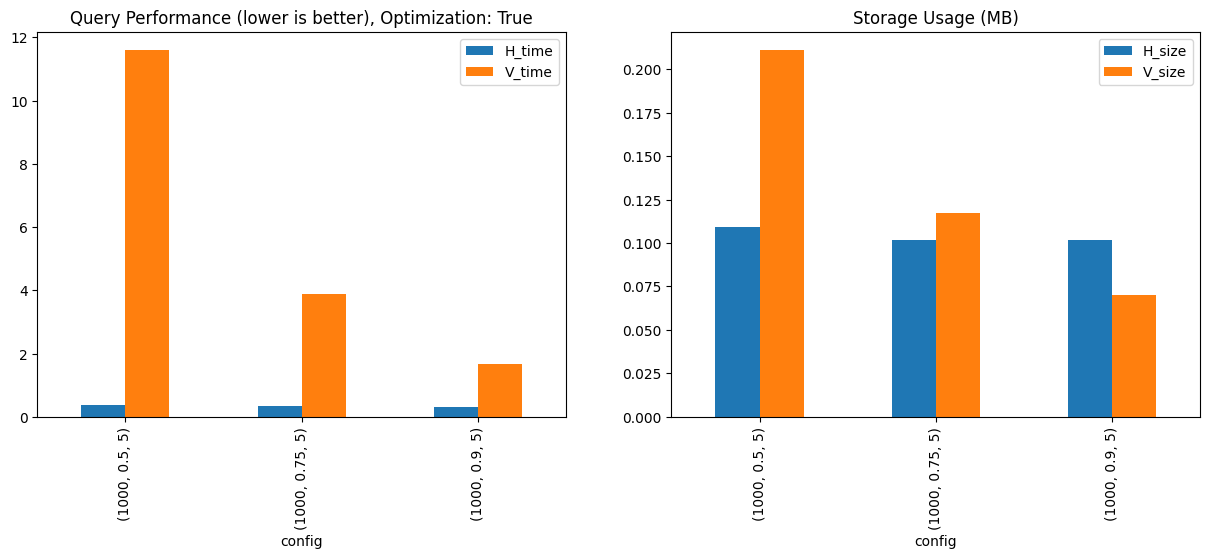

Eingaben: [(1000, 0.5, 5), (1000, 0.75, 5), (1000, 0.9, 5)]
Optimierung: False
Tabelle H mit 1000 Tupeln und 5 Attributen erstellt.
Executed 1000 queries in 0.35 seconds.
Speicherverbrauch von h: 0.11 MB
Speicherverbrauch von v_all: 0.13 MB
Tabelle H mit 1000 Tupeln und 5 Attributen erstellt.
Executed 1000 queries in 0.34 seconds.
Speicherverbrauch von h: 0.10 MB
Speicherverbrauch von v_all: 0.07 MB
Tabelle H mit 1000 Tupeln und 5 Attributen erstellt.
Executed 1000 queries in 0.38 seconds.
Speicherverbrauch von h: 0.10 MB
Speicherverbrauch von v_all: 0.04 MB


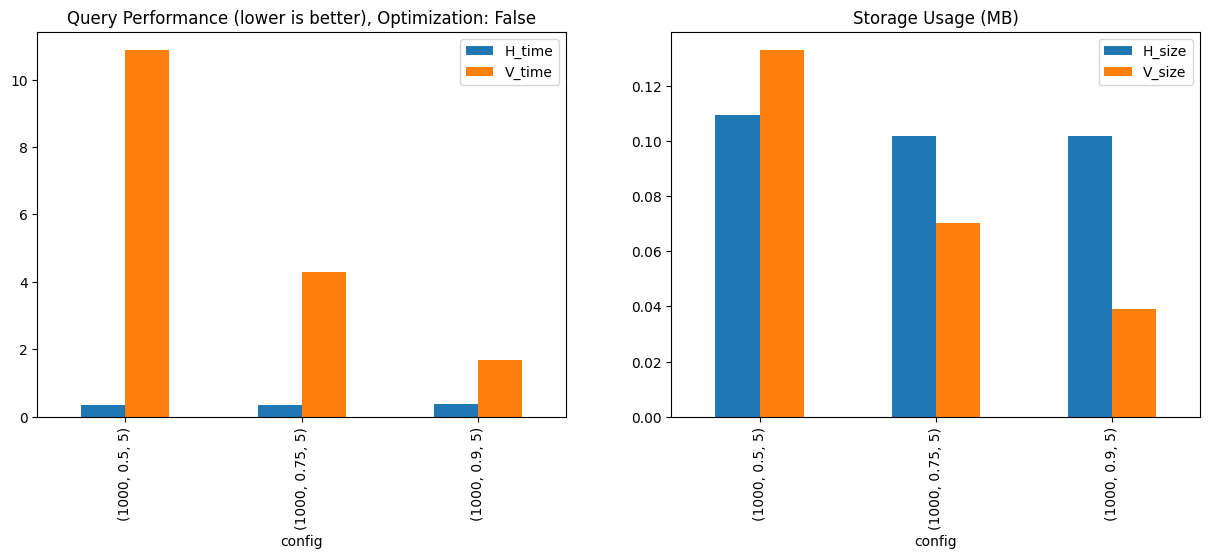

Eingaben: [(1000, 0.75, 5), (1000, 0.75, 10), (1000, 0.75, 20)]
Optimierung: True
Tabelle H mit 1000 Tupeln und 5 Attributen erstellt.
Executed 1000 queries in 0.38 seconds.
Speicherverbrauch von h: 0.10 MB
Indexe für v_all erstellt.
Speicherverbrauch von v_all: 0.12 MB
Tabelle H mit 1000 Tupeln und 10 Attributen erstellt.
Executed 1000 queries in 0.38 seconds.
Speicherverbrauch von h: 0.12 MB
Indexe für v_all erstellt.
Speicherverbrauch von v_all: 0.21 MB
Tabelle H mit 1000 Tupeln und 20 Attributen erstellt.
Executed 1000 queries in 0.47 seconds.
Speicherverbrauch von h: 0.13 MB
Indexe für v_all erstellt.
Speicherverbrauch von v_all: 0.37 MB


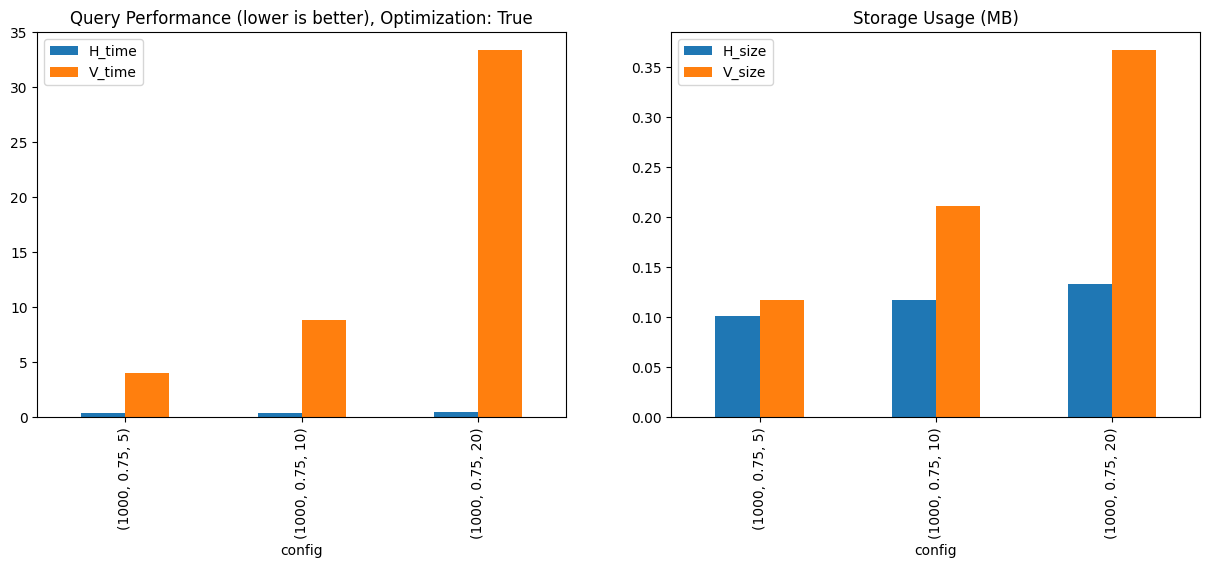

Eingaben: [(1000, 0.75, 5), (1000, 0.75, 10), (1000, 0.75, 20)]
Optimierung: False
Tabelle H mit 1000 Tupeln und 5 Attributen erstellt.
Executed 1000 queries in 0.36 seconds.
Speicherverbrauch von h: 0.10 MB
Speicherverbrauch von v_all: 0.07 MB
Tabelle H mit 1000 Tupeln und 10 Attributen erstellt.
Executed 1000 queries in 0.38 seconds.
Speicherverbrauch von h: 0.12 MB
Speicherverbrauch von v_all: 0.13 MB
Tabelle H mit 1000 Tupeln und 20 Attributen erstellt.
Executed 1000 queries in 0.43 seconds.
Speicherverbrauch von h: 0.13 MB
Speicherverbrauch von v_all: 0.26 MB


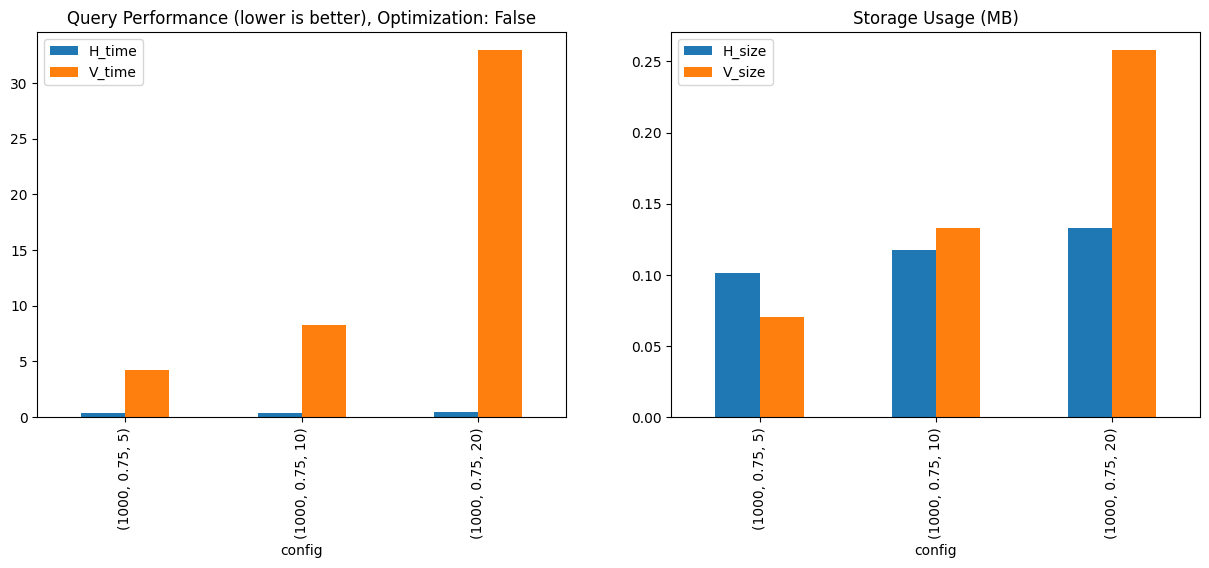

Eingaben: [(1000, 0.75, 5), (5000, 0.75, 5), (10000, 0.75, 5)]
Optimierung: True
Tabelle H mit 1000 Tupeln und 5 Attributen erstellt.
Executed 1000 queries in 0.33 seconds.
Speicherverbrauch von h: 0.10 MB
Indexe für v_all erstellt.
Speicherverbrauch von v_all: 0.12 MB
Tabelle H mit 5000 Tupeln und 5 Attributen erstellt.
Executed 1000 queries in 0.80 seconds.
Speicherverbrauch von h: 0.34 MB
Indexe für v_all erstellt.
Speicherverbrauch von v_all: 0.63 MB
Tabelle H mit 10000 Tupeln und 5 Attributen erstellt.
Executed 1000 queries in 1.15 seconds.
Speicherverbrauch von h: 0.63 MB
Indexe für v_all erstellt.
Speicherverbrauch von v_all: 0.77 MB


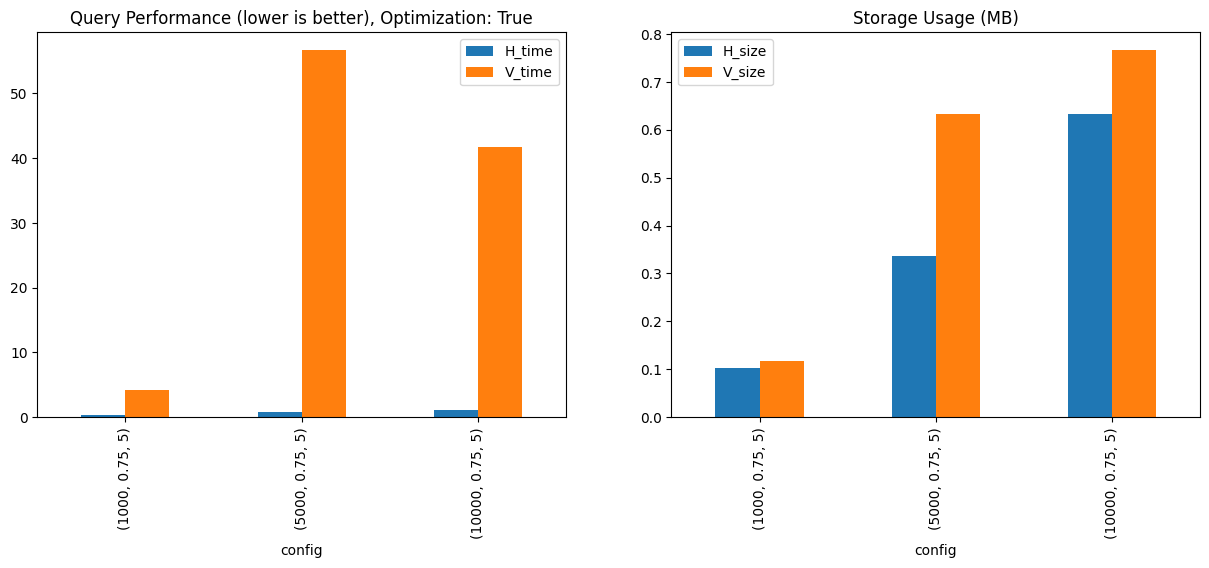

Eingaben: [(1000, 0.75, 5), (5000, 0.75, 5), (10000, 0.75, 5)]
Optimierung: False
Tabelle H mit 1000 Tupeln und 5 Attributen erstellt.
Executed 1000 queries in 0.34 seconds.
Speicherverbrauch von h: 0.10 MB
Speicherverbrauch von v_all: 0.07 MB
Tabelle H mit 5000 Tupeln und 5 Attributen erstellt.
Executed 1000 queries in 0.68 seconds.
Speicherverbrauch von h: 0.34 MB
Speicherverbrauch von v_all: 0.51 MB
Tabelle H mit 10000 Tupeln und 5 Attributen erstellt.
Executed 1000 queries in 1.11 seconds.
Speicherverbrauch von h: 0.63 MB
Speicherverbrauch von v_all: 1.01 MB


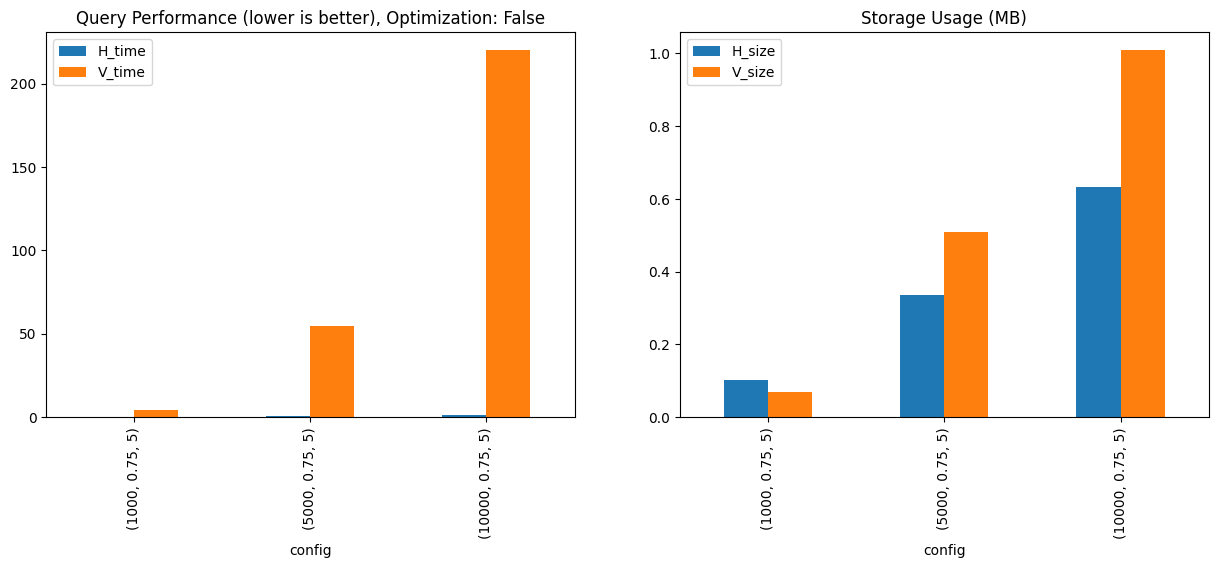

In [17]:
configs_list = [[(1000, 0.5, 5), (1000, 0.75, 5), (1000, 0.9, 5)],
            [(1000, 0.75, 5), (1000, 0.75, 10), (1000, 0.75, 20)],
            [(1000, 0.75, 5), (5000, 0.75, 5), (10000, 0.75, 5)]]   

for i in range(3):
    configs = configs_list[i]
    for opt in [True, False]:
        run_complete_benchmark(cursor, configs, opt=opt)


